In [ ]:

!pip install -q ultralytics roboflow opencv-python matplotlib

In [ ]:
!pip install scikit-learn joblib


In [ ]:
!pip install imbalanced-learn

In [ ]:
!pip install ultralytics opencv-python-headless -q


In [ ]:
from ultralytics import YOLO
from roboflow import Roboflow
import cv2
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
from glob import glob
import cv2

In [ ]:
ROBOFLOW_API_KEY = 'ZeqDUbrUSOriIWblOi1E'



In [ ]:
rf = Roboflow(api_key = ROBOFLOW_API_KEY)


In [ ]:
ROBOFLOW_WORKSPACE = 'keshandirisa'
ROBOFLOW_PROJECT = 'driver-behavior-ultimate-tunzj-8s7ie'
ROBOFLOW_VERSION = 1


In [ ]:
project = rf.workspace(ROBOFLOW_WORKSPACE).project(ROBOFLOW_PROJECT)
dataset = project.version(ROBOFLOW_VERSION).download('yolov8')

for v in project.versions():
    print(f" - Version: {v.id}, Images: {v.images}, Created at: {v.created}")



loading Roboflow workspace...
loading Roboflow project...
 - Version: keshandirisa/driver-behavior-ultimate-tunzj-8s7ie/1, Images: 8378, Created at: 1764624797.256


In [ ]:
dataset_dir = Path(dataset.location)
data_yaml = dataset_dir / 'data.yaml'

print('Dataset directory: ', dataset_dir)
print('data.yaml path: ', data_yaml)

assert data_yaml.exists(), 'data.yaml file does not exist'


Dataset directory:  /content/driver-behavior-ultimate-1
data.yaml path:  /content/driver-behavior-ultimate-1/data.yaml


### Inspecting the Data and Classes

In [ ]:
with open(data_yaml, 'r') as f:
  data_cfg = yaml.safe_load(f)

print('Classes: ', data_cfg.get('names'))
print('Train path:', data_cfg.get('train'))
print('Validation path:', data_cfg.get('val'))

Classes:  ['Drinking', 'Driver', 'Smoking', 'Using Phone']
Train path: ../train/images
Validation path: ../valid/images


In [ ]:
# Grabbing Training Images as a visual check
train_imgs = glob(str(dataset_dir / 'train' / 'images'/ '*'))
print('Number of training images: ', len(train_imgs))

Number of training images:  6579


Note there are 6579 training images

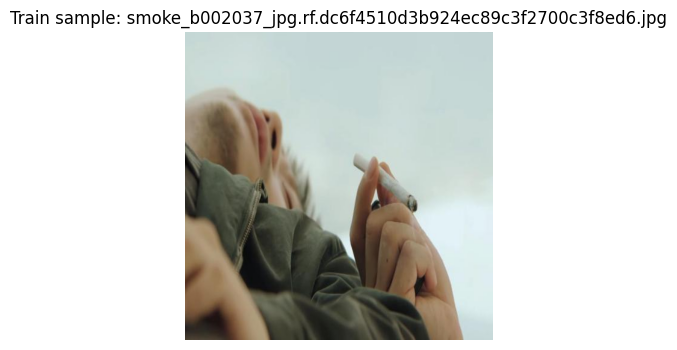

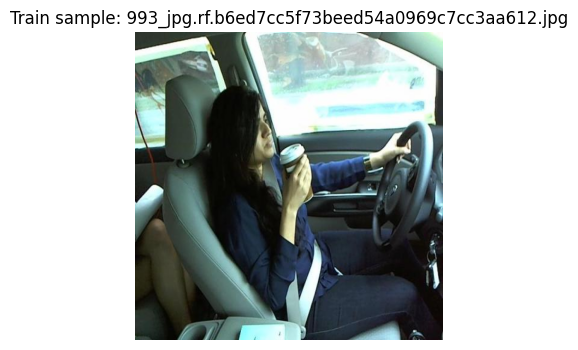

In [ ]:
for img_path in train_imgs[:3]:
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.figure(figsize = (6, 4))
  plt.imshow(img)
  plt.axis('off')
  plt.title(f'Train sample: {Path(img_path).name}')
  plt.show()

### Specifying the YOLOv11 Model

In [ ]:
!nvidia-smi

Tue Dec  2 05:22:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
MODEL_WEIGHTS = 'yolo11n.pt'
EPOCHS = 25
BATCH_SIZE = 16
IMG_SIZE = 640
DEVICE = 0
RUN_NAME = 'driver_behavior_yolo12n'

model = YOLO(MODEL_WEIGHTS)
model.info()

YOLO11n summary: 181 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs


(181, 2624080, 0, 6.614336)

#### Training the Model

In [ ]:
results = model.train(
    data = str(data_yaml),
    epochs = EPOCHS,
    batch = BATCH_SIZE,
    imgsz = IMG_SIZE,
    device = DEVICE,
    name = RUN_NAME,
    pretrained = True,
    workers = 4,
    patience = 10 # early stopping
)

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/driver-behavior-ultimate-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=driver_behavior_yolo12n2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, per

### Model Evaluation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

def evaluate_yolo_model(
    model,
    data_yaml,
    imgsz=640,
    device=0,
    conf=0.25,
    iou=0.5,
    results_dir=None,   # <- pass runs/detect/... directory to plot loss curves
):
    """
    Run validation for an Ultralytics YOLO model and show:
      - mAP metrics
      - Overall P / R / F1 / approx accuracy
      - Per-class metrics
      - Bar charts for AP, P, R, F1
      - Confusion matrix (if available)
      - Train & validation loss curves (if results.csv is available)
    """

    # ---- 1. Run validation ----
    metrics = model.val(
        data=str(data_yaml),
        imgsz=imgsz,
        device=device,
        conf=conf,
        iou=iou,
    )

    # ---- 2. Summary mAP metrics ----
    print("\n========== GLOBAL DETECTION METRICS ==========")
    print(f"mAP50-95 : {metrics.box.map:.4f}")
    print(f"mAP50    : {metrics.box.map50:.4f}")
    print(f"mAP75    : {metrics.box.map75:.4f}")

    # ---- 3. Per-class P/R/AP ----
    ap_per_class   = metrics.box.maps                  # AP per class
    prec_per_class = metrics.box.p                 # precision per class
    rec_per_class  = metrics.box.r                    # recall per class
    f1_per_class   = 2 * prec_per_class * rec_per_class / (prec_per_class + rec_per_class + 1e-9)

    # Approx per-class accuracy using P, R
    acc_per_class = []
    for P, R in zip(prec_per_class, rec_per_class):
        TP = R
        FP = TP * (1 / P - 1) if P > 0 else 0.0
        FN = 1 - R
        denom = TP + FP + FN
        acc = TP / denom if denom > 0 else 0.0
        acc_per_class.append(acc)
    acc_per_class = np.array(acc_per_class)

    overall_precision = float(np.mean(prec_per_class))
    overall_recall    = float(np.mean(rec_per_class))
    overall_f1        = float(np.mean(f1_per_class))
    overall_acc       = float(np.mean(acc_per_class))

    print("\n========== GLOBAL CLASSIFICATION SUMMARY ==========")
    print(f"Overall Precision : {overall_precision:.4f}")
    print(f"Overall Recall    : {overall_recall:.4f}")
    print(f"Overall F1        : {overall_f1:.4f}")
    print(f"Approx Accuracy   : {overall_acc:.4f}")

    # ---- 4. Per-class breakdown ----
    print("\n========== PER-CLASS METRICS ==========")
    for cls_id, cls_name in metrics.names.items():
        print(
            f"[{cls_id}] {cls_name:20s} | "
            f"AP={ap_per_class[cls_id]:.3f} | "
            f"P={prec_per_class[cls_id]:.3f} | "
            f"R={rec_per_class[cls_id]:.3f} | "
            f"F1={f1_per_class[cls_id]:.3f} | "
            f"Acc\u2248{acc_per_class[cls_id]:.3f}"
        )

    # ---- 5. Bar charts for AP, P, R, F1 ----
    classes = [metrics.names[i] for i in range(len(metrics.names))]
    x = np.arange(len(classes))

    def _barplot(values, title, ylabel):
        plt.figure(figsize=(max(8, len(classes) * 0.6), 4))
        plt.bar(x, values)
        plt.xticks(x, classes, rotation=45, ha="right")
        plt.title(title)
        plt.ylabel(ylabel)
        plt.tight_layout()
        plt.show()

    _barplot(ap_per_class,   "Average Precision (AP) per Class", "AP")
    _barplot(prec_per_class, "Precision per Class",              "Precision")
    _barplot(rec_per_class,  "Recall per Class",                 "Recall")
    _barplot(f1_per_class,   "F1 Score per Class",               "F1")

    # ---- 6. Confusion matrix (if available) ----
    cm = None
    if hasattr(metrics, "confusion_matrix") and metrics.confusion_matrix is not None:
        try:
            cm = metrics.confusion_matrix.matrix
        except AttributeError:
            cm = getattr(metrics.confusion_matrix, "matrix", None)

    if cm is not None:
        # For detection tasks, confusion matrix is (nc+1, nc+1); last row/col are background
        if cm.shape[0] == len(classes) + 1:
            cm = cm[:-1, :-1]

        cm_norm = cm / (cm.sum(axis=1, keepdims=True) + 1e-9)

        plt.figure(figsize=(max(8, len(classes) * 0.6), max(6, len(classes) * 0.6)))
        im = plt.imshow(cm_norm, interpolation="nearest", cmap="Blues")
        plt.title("Normalized Confusion Matrix")
        plt.colorbar(im, fraction=0.046, pad=0.04)
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45, ha="right")
        plt.yticks(tick_marks, classes)
        plt.ylabel("True Class")
        plt.xlabel("Predicted Class")
        plt.tight_layout()
        plt.show()
    else:
        print("\n[Info] Confusion matrix not available on metrics; "
              "update Ultralytics if you need it.")

    # ---- 7. Train & validation loss curves (from results.csv) ----
    if results_dir is None:
        # Try to infer from model.trainer if still in the same session
        save_dir = getattr(getattr(model, "trainer", None), "save_dir", None)
        if save_dir is not None:
            results_dir = Path(save_dir)
        else:
            print("\n[Info] results_dir not provided and could not infer from model.trainer; "
                  "skipping loss curves.")
            results_csv = None
    else:
        results_dir = Path(results_dir)
        results_csv = results_dir / "results.csv"

    if results_dir is not None:
        results_csv = results_dir / "results.csv"
        if results_csv.exists():
            print(f"\n[Info] Loading training history from: {results_csv}")
            df = pd.read_csv(results_csv)

            if "epoch" not in df.columns:
                print("[Warning] 'epoch' column not found in results.csv; skipping loss curves.")
            else:
                # Identify loss columns
                train_loss_cols = [c for c in df.columns if c.startswith("train/") and c.endswith("_loss")]
                val_loss_cols   = [c for c in df.columns if c.startswith("val/")   and c.endswith("_loss")]

                if not train_loss_cols or not val_loss_cols:
                    print("[Warning] No train/val loss columns found in results.csv; "
                          "column names may differ in your version.")
                else:
                    df["train_total_loss"] = df[train_loss_cols].sum(axis=1)
                    df["val_total_loss"]   = df[val_loss_cols].sum(axis=1)

                    plt.figure(figsize=(8, 5))
                    plt.plot(df["epoch"], df["train_total_loss"], label="Train total loss")
                    plt.plot(df["epoch"], df["val_total_loss"],   label="Val total loss")
                    plt.xlabel("Epoch")
                    plt.ylabel("Loss")
                    plt.title("Train vs Validation Loss")
                    plt.legend()
                    plt.grid(True, alpha=0.3)
                    plt.tight_layout()
                    plt.show()
        else:
            print(f"\n[Info] results.csv not found in {results_dir}; skipping loss curves.")

    return {
        "metrics": metrics,
        "ap_per_class": ap_per_class,
        "precision_per_class": prec_per_class,
        "recall_per_class": rec_per_class,
        "f1_per_class": f1_per_class,
        "accuracy_per_class": acc_per_class,
        "overall": {
            "precision": overall_precision,
            "recall": overall_recall,
            "f1": overall_f1,
            "accuracy": overall_acc,
            "map50_95": float(metrics.box.map),
            "map50": float(metrics.box.map50),
            "map75": float(metrics.box.map75),
        },
    }

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1512.2±522.4 MB/s, size: 36.4 KB)
val: Scanning /content/driver-behavior-ultimate-1/valid/labels.cache... 1713 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1713/1713 2.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 108/108 5.6it/s 19.4s
                   all       1713       3541      0.846      0.784      0.832      0.601
              Drinking        381        406      0.903      0.904      0.937       0.75
                Driver       1528       1703      0.923       0.93      0.946      0.754
               Smoking        694        720      0.758      0.596       0.67      0.343
           Using Phone        615        712      0.801      0.705      0.774      0.558
Speed: 1.5ms preprocess, 3.8ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /conte

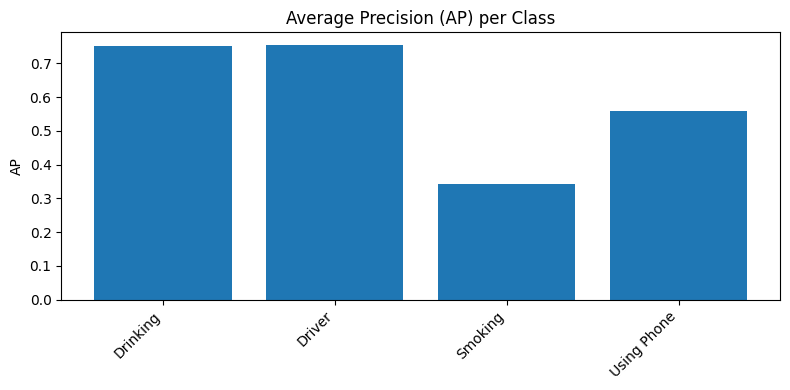

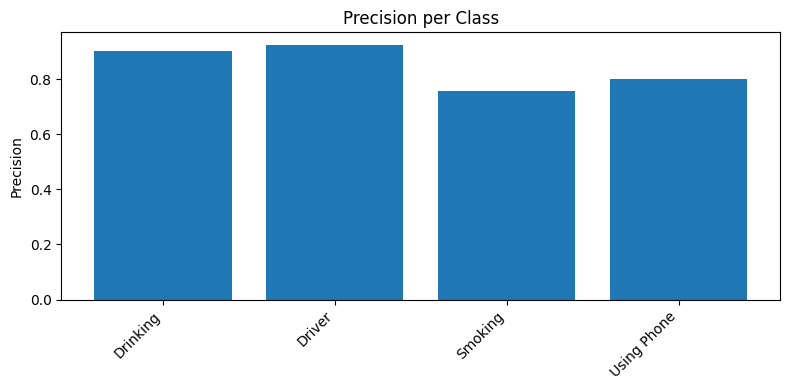

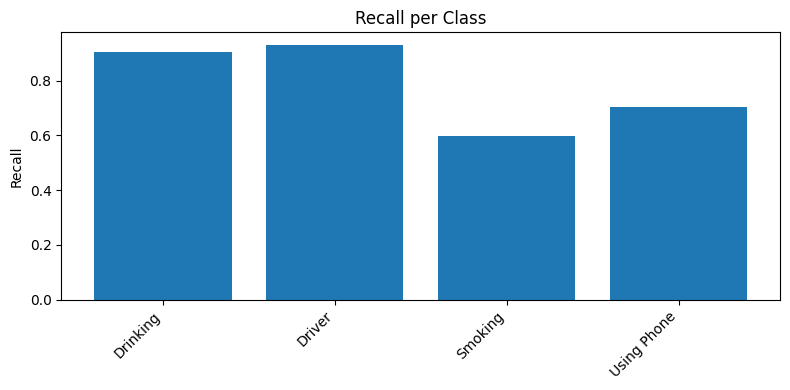

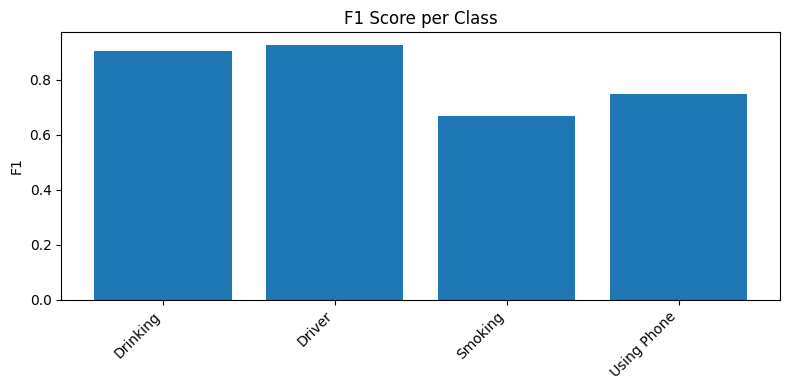

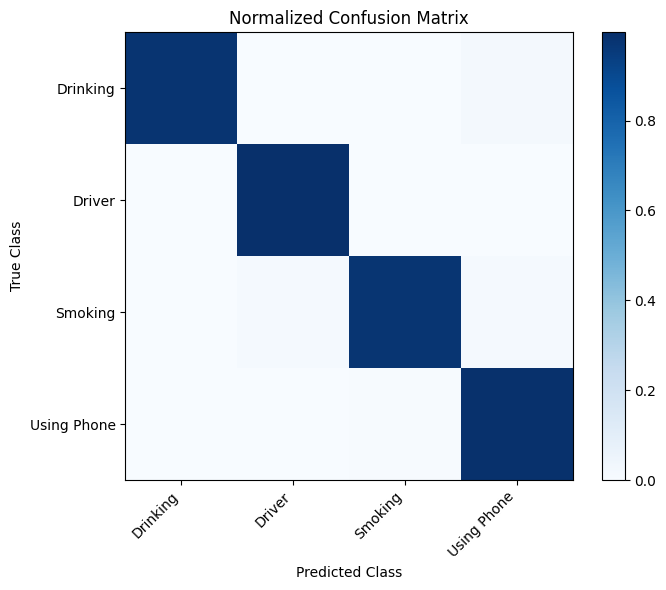


[Info] Loading training history from: /content/runs/detect/driver_behavior_yolo12n2/results.csv


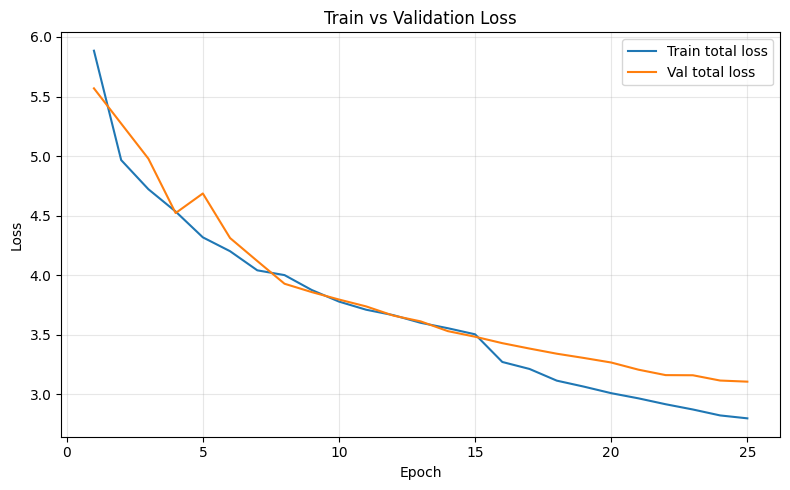

In [ ]:
results_dict = evaluate_yolo_model(
    model,
    data_yaml=data_yaml,
    imgsz=IMG_SIZE,
    device=DEVICE,
    conf=0.25,
    iou=0.5,
    # results_dir optional; if omitted, it tries model.trainer.save_dir
)


### Visualising predictions on validation images
Drawing bounding boxes on validation images

In [ ]:
val_imgs = glob(str(dataset_dir / 'valid' / 'images'/ '*'))
print('Number of validation images: ', len(val_imgs))

Number of validation images:  1713


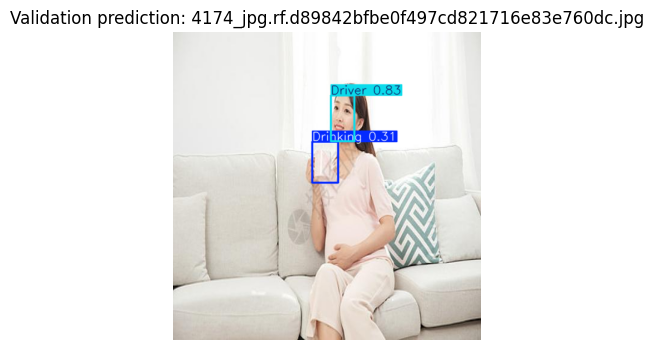

In [ ]:
for img_path in val_imgs[:3]:
  results = model.predict(
      source = img_path,
      imgsz = IMG_SIZE,
      conf = 0.25,
      device = DEVICE,
      verbose = False
  )

annoted = results[0].plot() # draws bounding boxes and labels
annoted = cv2.cvtColor(annoted, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (6, 4))
plt.imshow(annoted)
plt.axis('off')
plt.title(f'Validation prediction: {Path(img_path).name}')
plt.show()

### Loading the Best Model Weights

In [ ]:
actual_run_name = 'driver_behavior_yolo12n2'
best_weights = Path('runs')/'detect'/actual_run_name/'weights'/'best.pt'
print('Best weights path: ', best_weights.resolve())
assert best_weights.exists(), 'best.pt does not exist'

y11_model = YOLO(str(best_weights))

Best weights path:  /content/runs/detect/driver_behavior_yolo12n2/weights/best.pt


#### Run Predictions on test images

In [ ]:
test_imgs = glob(str(dataset_dir / 'test' / 'images'/ '*'))
print('Number of test images: ', len(test_imgs))

Number of test images:  86


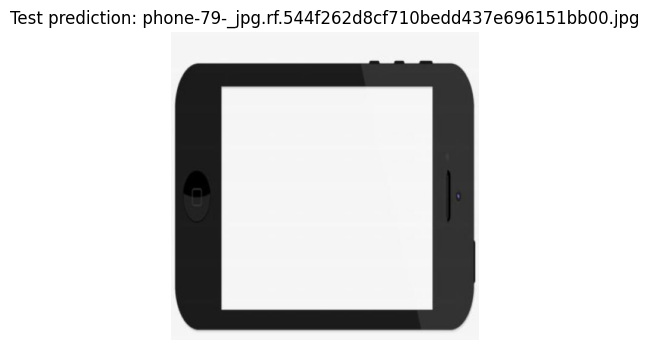

In [ ]:
for img_path in test_imgs[:3]:
  results = y11_model.predict(
       source = img_path,
       imgsz = IMG_SIZE,
       conf = 0.25,
       device = DEVICE,
       verbose = False
  )

annotated = results[0].plot()
annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (6, 4))
plt.imshow(annotated)
plt.axis('off')
plt.title(f'Test prediction: {Path(img_path).name}')
plt.show()


### Risk Analysis

In [ ]:
# creating a risk map to dataset classes to a risk category
risk_map = {
    'Driver': 0,
    'Drinking' : 1,
    'Using Phone' : 2,
    'Smoking' : 3
}

DEFAULT_RISK_LVL = 0

In [ ]:
def get_image_risk_label(label_path: Path, class_names, risk_map, default=0):
    """
    Read a YOLO label file and return an integer risk level for the image.
    We take the MAX risk among all objects in the image.
    """
    if not label_path.exists():
        return default

    risks = []
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            cls_id = int(parts[0])
            cls_name = class_names[cls_id]
            risks.append(risk_map.get(cls_name, default))

    if not risks:
        return default
    return max(risks)


In [ ]:
def risk_level_to_binary(risk_level: int) -> int:
    """
    Convert multi-level risk (0,1,2,...) to binary:
    0 = safe, 1 = risky
    """
    return 1 if risk_level > 0 else 0


In [ ]:
import numpy as np
import cv2

class_names = data_cfg.get('names')
n_classes = len(class_names)

def features_from_results(results, n_classes: int):
    """
    Build a fixed-length feature vector from YOLO Results for one image.
    For each class: [count, max_conf, mean_area].
    """
    feat = np.zeros(n_classes * 3, dtype=np.float32)

    img_h, img_w = results.orig_img.shape[:2]
    boxes = results.boxes

    if boxes is None or len(boxes) == 0:
        return feat

    for box in boxes:
        cls = int(box.cls.item())
        conf = float(box.conf.item())
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        area = (x2 - x1) * (y2 - y1) / (img_w * img_h + 1e-9)  # normalized

        base = cls * 3
        # count
        feat[base] += 1
        # max confidence
        feat[base + 1] = max(feat[base + 1], conf)
        # sum of areas for now; convert to mean later
        feat[base + 2] += area

    # Convert area sums to means
    for cls in range(n_classes):
        base = cls * 3
        count = feat[base]
        if count > 0:
            feat[base + 2] /= count

    return feat

In [ ]:
from glob import glob

split = "valid"  # or "train"
img_dir = dataset_dir / split / "images"
lbl_dir = dataset_dir / split / "labels"

image_paths = sorted(glob(str(img_dir / "*")))
print(f"{split} images used for risk model:", len(image_paths))

X, y = [], []

for img_path in image_paths:
    img_path = Path(img_path)
    label_path = lbl_dir / (img_path.stem + ".txt")

    # Ground-truth risk label
    risk_level = get_image_risk_label(label_path, class_names, risk_map, DEFAULT_RISK_LVL)
    y_bin = risk_level_to_binary(risk_level)

    # YOLO detections as features
    # (We can resize to IMG_SIZE for consistency, but YOLO handles it internally.)
    results = y11_model(str(img_path), imgsz=IMG_SIZE, conf=0.25, verbose=False)[0]
    feat = features_from_results(results, n_classes=n_classes)

    X.append(feat)
    y.append(y_bin)

X = np.stack(X, axis=0)
y = np.array(y, dtype=np.int64)

print("Feature matrix shape:", X.shape)
print("Binary labels shape :", y.shape, "| #risky:", y.sum(), "| #safe:", (y == 0).sum())

valid images used for risk model: 1713
Feature matrix shape: (1713, 12)
Binary labels shape : (1713,) | #risky: 1684 | #safe: 29


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import joblib
from imblearn.over_sampling import SMOTE

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Apply SMOTE only on the training set
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Base and calibrated classifier
base_clf = LogisticRegression(max_iter=500)
risk_clf = CalibratedClassifierCV(base_clf, method="isotonic", cv=3)

# Fit on the resampled training data
risk_clf.fit(X_train_res, y_train_res)

# Evaluate on untouched validation data
probs_val = risk_clf.predict_proba(X_val)[:, 1]  # P(risky)
preds_val = (probs_val >= 0.5).astype(int)

print("ROC AUC:", roc_auc_score(y_val, probs_val))
print("\nClassification report:")
print(classification_report(y_val, preds_val, target_names=["safe", "risky"]))

print("Confusion matrix (safe=0, risky=1):")
print(confusion_matrix(y_val, preds_val))

# Save risk model
joblib.dump(risk_clf, "risk_classifier.joblib")
print("Saved risk classifier to risk_classifier.joblib")


ROC AUC: 0.670375865479723

Classification report:
              precision    recall  f1-score   support

        safe       0.02      0.50      0.05         6
       risky       0.99      0.63      0.77       337

    accuracy                           0.63       343
   macro avg       0.50      0.57      0.41       343
weighted avg       0.97      0.63      0.76       343

Confusion matrix (safe=0, risky=1):
[[  3   3]
 [124 213]]
Saved risk classifier to risk_classifier.joblib


Processing 3 test images...


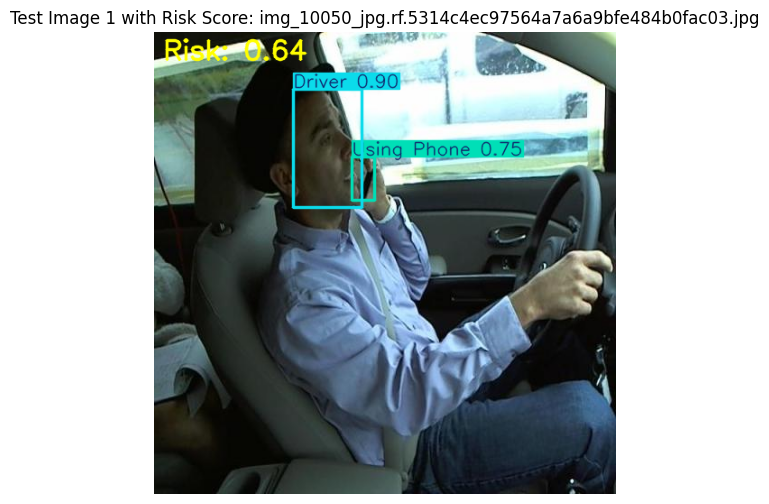

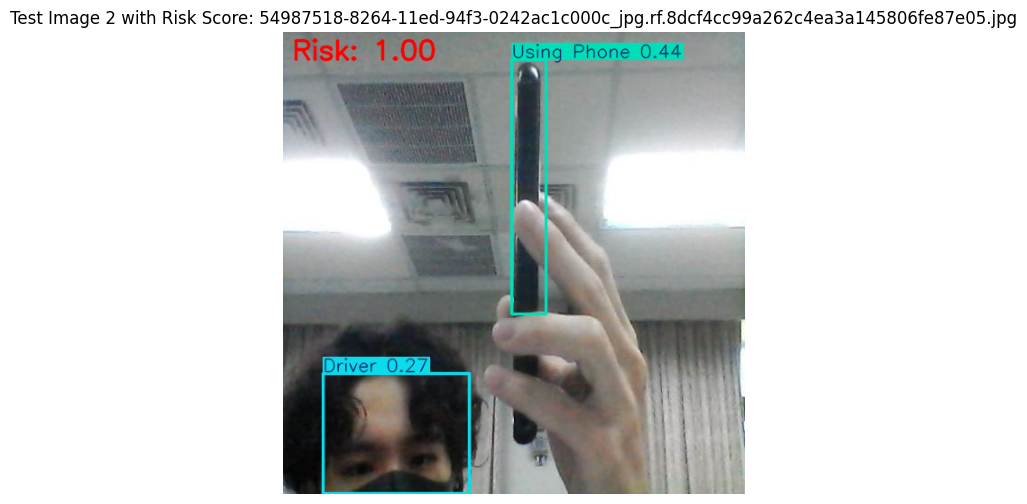

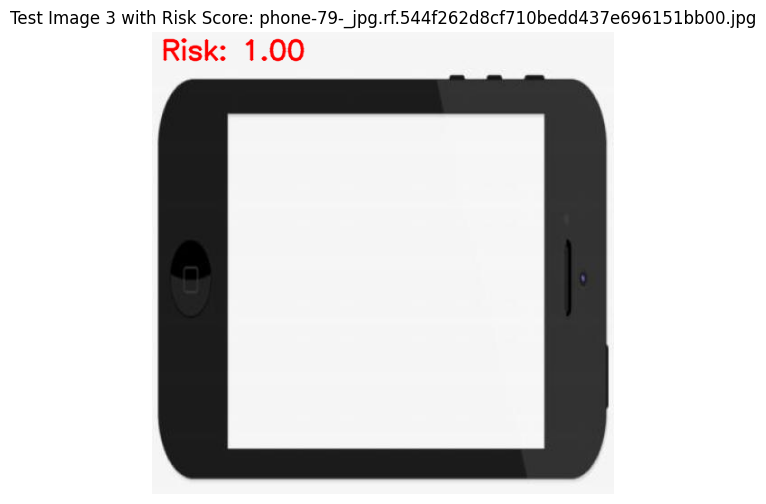

Demonstration complete for selected test images.


In [ ]:
import cv2
import joblib
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib

# Reload (optional, if in a new session)
y11_model = YOLO(str(best_weights))
risk_clf = joblib.load("risk_classifier.joblib")

def risk_features_from_frame(results):
    return features_from_results(results, n_classes=n_classes).reshape(1, -1)

# Get a few test images to demonstrate
# Assuming 'test_imgs' is already defined from a previous cell
if 'test_imgs' not in locals():
    test_imgs = glob(str(dataset_dir / 'test' / 'images'/ '*'))

print(f"Processing {min(3, len(test_imgs))} test images...")

for i, img_path in enumerate(test_imgs[:3]): # Process first 3 test images
    # YOLO inference
    results = y11_model(img_path, imgsz=IMG_SIZE, conf=0.25, verbose=False)[0]

    # Risk features + prediction
    feat = risk_features_from_frame(results)
    prob_risky = float(risk_clf.predict_proba(feat)[0, 1])  # P(risky)

    # Draw detections
    annotated = results.plot()
    annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB) # Convert BGR to RGB for matplotlib

    # Overlay risk
    text = f"Risk: {prob_risky:.2f}"
    if prob_risky < 0.33:
        color = (0, 255, 0)   # green
    elif prob_risky < 0.66:
        color = (255, 255, 0) # yellow (changed from BGR (0,255,255) to RGB for consistency)
    else:
        color = (255, 0, 0)   # red (changed from BGR (0,0,255) to RGB for consistency)

    # For text, we need to convert color to BGR if using cv2.putText, or handle for matplotlib
    # Since `annotated` is now RGB, let's keep text color in RGB as well for consistency if possible
    # However, cv2.putText expects BGR for the image it draws on, so let's convert annotated back to BGR temporarily for text
    temp_annotated = cv2.cvtColor(annotated, cv2.COLOR_RGB2BGR)
    cv2.putText(
        temp_annotated,
        text,
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.0,
        (color[2], color[1], color[0]), # Convert RGB color to BGR for cv2.putText
        2,
        cv2.LINE_AA
    )
    annotated = cv2.cvtColor(temp_annotated, cv2.COLOR_BGR2RGB) # Convert back to RGB for matplotlib

    # Display using matplotlib
    plt.figure(figsize = (8, 6))
    plt.imshow(annotated)
    plt.axis('off')
    plt.title(f'Test Image {i+1} with Risk Score: {Path(img_path).name}')
    plt.show()

print("Demonstration complete for selected test images.")

# Removed cv2.VideoCapture and cv2.imshow for headless environment compatibility
# cap.release()
# cv2.destroyAllWindows()


In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from google.colab import files
from google.colab.patches import cv2_imshow

In [ ]:
def select_video():
    """
    Helper to upload a video file from your local machine and
    return the path that OpenCV can read.
    """
    print("Upload a driver video file (e.g. driver_video.mp4)...")
    uploaded = files.upload()

    # Take first uploaded file
    video_path = next(iter(uploaded.keys()))
    print(f"Using video: {video_path}")
    return video_path


video_path = select_video()
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    raise RuntimeError("Failed to open the uploaded video. Check the file format.")

Upload a driver video file (e.g. driver_video.mp4)...


StopIteration: 

In [ ]:
# Load YOLOv12 model (update path/weights as needed)
y11_model = YOLO("yolov12n.pt")   # or your fine-tuned weights path
IMG_SIZE = 640

# Define which classes are considered risky
# Change these to match your model's class names
RISKY_CLASSES = {
    "phone",        # driver using phone
    "smoking",      # driver smoking
    "no_seatbelt",  # no seatbelt
    "distracted"    # generic distracted behavior
}

def compute_risk_score(result, model):
    """
    Given a YOLO result for one frame, compute a risk score in [0, 1].

    Example logic:
      - For each detection belonging to a risky class, add its confidence.
      - Clip final score at 1.0.
    """
    boxes = result.boxes
    if boxes is None or len(boxes) == 0:
        return 0.0

    # Names: id -> class string
    names = result.names if hasattr(result, "names") and result.names else model.names

    cls_ids = boxes.cls.cpu().numpy()
    confs   = boxes.conf.cpu().numpy()

    risk_score = 0.0
    for cls_id, conf in zip(cls_ids, confs):
        cls_name = names[int(cls_id)]
        if cls_name in RISKY_CLASSES:
            risk_score += float(conf)

    # Normalize / clip to [0,1]
    risk_score = max(0.0, min(1.0, risk_score))
    return risk_score


def draw_risk_overlay(frame, risk_score):
    """
    Draw a risk score banner on the frame.
    Color shifts from green (safe) → yellow → red (high risk).
    """
    h, w = frame.shape[:2]

    # Risk-based color
    if risk_score < 0.33:
        color = (0, 255, 0)    # green
    elif risk_score < 0.66:
        color = (0, 255, 255)  # yellow
    else:
        color = (0, 0, 255)    # red

    # Draw semi-opaque rectangle at top
    overlay = frame.copy()
    cv2.rectangle(overlay, (0, 0), (w, 60), (0, 0, 0), -1)
    alpha = 0.6
    frame = cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0)

    # Text
    text = f"Risk score: {risk_score:.2f}"
    cv2.putText(
        frame,
        text,
        (20, 40),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.0,
        color,
        2,
        cv2.LINE_AA,
    )

    return frame

In [ ]:
# Main inference loop for Colab (video-based "webcam")
frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        print("End of video stream.")
        break

    frame_count += 1

    # Run YOLOv12 on the frame
    results = y11_model(frame, imgsz=IMG_SIZE, conf=0.25, verbose=False)

    # Plot detections
    annotated = results[0].plot()

    # Compute risk score for this frame
    risk = compute_risk_score(results[0], y11_model)

    # Draw risk overlay
    annotated = draw_risk_overlay(annotated, risk)

    # Show in Colab notebook
    cv2_imshow(annotated)

    # Small break to avoid flooding output (optional)
    # In Colab there's no keyboard event like 'q', so just interrupt the cell to stop early
    if frame_count >= 300:  # limit output a bit for sanity; adjust or remove
        print("Stopping after 300 frames to avoid huge output. Adjust/remove this limit as needed.")
        break

cap.release()
cv2.destroyAllWindows()